In [2]:
import os
import sys
import pytz
import numpy as np
import umap
import plotly.express as px

current_path = os.getcwd()
src_path = os.path.abspath(os.path.join(current_path, '..', 'src', 'Python'))
sys.path.insert(0, src_path) 
from feature_extraction import *
from feature_generation import *

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

In [6]:
# Load EDF info
path_to_edf = '../data/test12_Wednesday_05_ALL_PROCESSED.edf'
raw = mne.io.read_raw_edf(path_to_edf, include=['ECG_Raw_Ch1', 'EEG_ICA5', 'Pressure', 'ODBA', 'GyrZ'], preload=True)
info = raw.info

sfreq = info['sfreq']
edf_start_time = info['meas_date']
# Define the PST timezone
pst_timezone = pytz.timezone('America/Los_Angeles')
# Convert to datetime object in PST
if isinstance(edf_start_time, datetime.datetime):
    # If it's already a datetime object, just replace the timezone
    recording_start_datetime = edf_start_time.replace(tzinfo=None).astimezone(pst_timezone)
    # for some reason using .replace(tzinfo=...) does weird shit - offsets based of LMT instead of UTC and gets confusing
    # recording_start_datetime = edf_start_time.replace(tzinfo=pst_timezone)
elif isinstance(edf_start_time, (int, float)):
    # Convert timestamp to datetime in PST
    recording_start_datetime = pst_timezone.localize(datetime.datetime.fromtimestamp(edf_start_time))

# Load Labels
file_path = '../data/test12_Wednesday_06_Hypnogram_JKB_1Hz.csv'
df = pd.read_csv(file_path)
df['R.Time'] = pd.to_datetime(df['R.Time']).dt.tz_localize('America/Los_Angeles')
df['Sleep.Code'].value_counts(normalize=True)


Extracting EDF parameters from /Users/michael/Desktop/capstone-seal-sleep/jessie-workshop/ecophys-ecoviz/data/test12_Wednesday_05_ALL_PROCESSED.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 158957499  =      0.000 ... 317914.998 secs...


Sleep.Code
Active Waking         0.456175
Quiet Waking          0.143221
HV Slow Wave Sleep    0.124564
Drowsiness            0.075781
Certain REM Sleep     0.072228
LV Slow Wave Sleep    0.071997
Putative REM Sleep    0.034134
Unscorable            0.021901
Name: proportion, dtype: float64

# Load features
Skip ahead to [Read in features](#read_in_features) if you have already computed and saved the features

In [13]:
# Load features
features_all = generate_features(path_to_edf)

Extracting EDF parameters from /Users/michael/Desktop/capstone-seal-sleep/jessie-workshop/ecophys-ecoviz/data/test12_Wednesday_05_ALL_PROCESSED.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 158957499  =      0.000 ... 317914.998 secs...
starting heart rate


/Users/michael/Desktop/capstone-seal-sleep/jessie-workshop/ecophys-ecoviz/src/Python/feature_extraction.py:279: RuntimeWarning: divide by zero encountered in double_scalars
  heart_rates = [60 / ((rpeaks_corrected[i+1] - rpeaks_corrected[i]) / fs) for i in range(len(rpeaks_corrected) - 1)]


Filled: 0
done

--------------------------------------------------
starting hr_mean / hr_std
done

--------------------------------------------------
starting vlf power


/Users/michael/Desktop/capstone-seal-sleep/jessie-workshop/ecophys-ecoviz/src/Python/feature_extraction.py:197: RuntimeWarning: divide by zero encountered in log
  delta_power = 10 * np.log(np.sum(power_spectrum[delta_freq_indices]) * freq_resolution / ref_power)


done

--------------------------------------------------
starting yasa features
done

--------------------------------------------------
NA Values:
 Time                                      0
Heart Rate                                0
Heart Rate Mean                          29
Heart Rate Std.Dev                       29
Heart Rate Very Low Frequency Power      29
Heart Rate VLF Power Std.Dev           3215
Pressure Mean                            29
Pressure Std.Dev                         29
ODBA Mean                                29
ODBA Std.Dev                             29
GyrZ Mean                                29
GyrZ Std.Dev                             29
yasa_time                                 0
yasa_eeg_std                             18
yasa_eeg_iqr                             18
yasa_eeg_skew                            18
yasa_eeg_kurt                            18
yasa_eeg_nzc                             18
yasa_eeg_hmob                            18
yasa_eeg_hcomp 

In [16]:
# Data with target, drop start and end sections that aren't scored because sensors not set up yet or taking off
features_labeled = features_all[(features_all['Time'] >= df['R.Time'].min()) &
                               (features_all['Time'] <= df['R.Time'].max())]
features_labeled = features_labeled.set_index('Time', drop=True).drop('yasa_time', axis=1)
features_labeled[['Sleep.Num', 'Simple.Sleep.Code']] = df.set_index('R.Time', drop=True)[['Sleep.Num',
                                                                                          'Simple.Sleep.Code']]
features_labeled.to_csv('../traintest/train/Wednesday_features_v2_with_labels.csv')

<a id='read_in_features'></a>
## Read features (start here if features are already saved)

In [7]:
features_labeled = pd.read_csv('../traintest/train/Wednesday_features_v2_with_labels.csv')

In [19]:
model_data = features_labeled.drop('Sleep.Num', axis=1).dropna()
X, y = model_data.drop('Simple.Sleep.Code', axis=1), model_data['Simple.Sleep.Code']

In [50]:
params = {
    'learning_rate': [0.0001, 0.005, 0.01, 0.05, 0.1],
    'num_leaves': [10, 20, 40, 80],
    'n_estimators': [25, 100, 400]
}

In [55]:
model = LGBMClassifier()
grid = GridSearchCV(model, params, scoring='f1_weighted', verbose=2, n_jobs=8)
grid.fit(X, y)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021848 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 235697, number of used features: 32
[LightGBM] [Info] Start training from score -0.785168
[LightGBM] [Info] Start training from score -2.579648
[LightGBM] [Info] Start training from score -1.943122
[LightGBM] [Info] Start training from score -2.240676
[LightGBM] [Info] Start training from score -1.626542
[LightGBM] [Info] Start training from score -3.821029
[CV] END learning_rate=0.0001, n_estimators=25, num_leaves=20; total time=  18.7s
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] 

/Users/michael/anaconda3/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022693 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 235697, number of used features: 32
[LightGBM] [Info] Start training from score -0.785168
[LightGBM] [Info] Start training from score -2.579704
[LightGBM] [Info] Start training from score -1.943122
[LightGBM] [Info] Start training from score -2.240676
[LightGBM] [Info] Start training from score -1.626542
[LightGBM] [Info] Start training from score -3.820836
[CV] END learning_rate=0.0001, n_estimators=25, num_leaves=20; total time=  18.7s
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testin

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008052 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 235697, number of used features: 32
[LightGBM] [Info] Start training from score -0.785168
[LightGBM] [Info] Start training from score -2.579704
[LightGBM] [Info] Start training from score -1.943122
[LightGBM] [Info] Start training from score -2.240676
[LightGBM] [Info] Start training from score -1.626542
[LightGBM] [Info] Start training from score -3.820836
[CV] END learning_rate=0.005, n_estimators=25, num_leaves=20; total time=  12.7s
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.109479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 235696, number of used features: 32
[LightGBM] [Info] Start training from score -0.785164
[LightGBM] [Info] Start training from score -2.579699
[LightGBM] [Info] Start training from score -1.943148
[LightGBM] [Info] Start training from score -2.240632
[LightGBM] [Info] Start training from score -1.626537
[LightGBM] [Info] Start training from score -3.821025
[CV] END learning_rate=0.0001, n_estimators=25, num_leaves=10; total time=  10.9s
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testin

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008784 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 235697, number of used features: 32
[LightGBM] [Info] Start training from score -0.785168
[LightGBM] [Info] Start training from score -2.579648
[LightGBM] [Info] Start training from score -1.943122
[LightGBM] [Info] Start training from score -2.240676
[LightGBM] [Info] Start training from score -1.626542
[LightGBM] [Info] Start training from score -3.821029
[CV] END learning_rate=0.005, n_estimators=25, num_leaves=40; total time=  24.2s
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007675 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 235697, number of used features: 32
[LightGBM] [Info] Start training from score -0.785168
[LightGBM] [Info] Start training from score -2.579648
[LightGBM] [Info] Start training from score -1.943122
[LightGBM] [Info] Start training from score -2.240676
[LightGBM] [Info] Start training from score -1.626542
[LightGBM] [Info] Start training from score -3.821029
[CV] END learning_rate=0.005, n_estimators=100, num_leaves=10; total time=  30.6s
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testin

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026539 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 235697, number of used features: 32
[LightGBM] [Info] Start training from score -0.785168
[LightGBM] [Info] Start training from score -2.579648
[LightGBM] [Info] Start training from score -1.943122
[LightGBM] [Info] Start training from score -2.240676
[LightGBM] [Info] Start training from score -1.626542
[LightGBM] [Info] Start training from score -3.821029
[CV] END learning_rate=0.0001, n_estimators=25, num_leaves=10; total time=  11.0s
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testin

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060413 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 235697, number of used features: 32
[LightGBM] [Info] Start training from score -0.785168
[LightGBM] [Info] Start training from score -2.579704
[LightGBM] [Info] Start training from score -1.943122
[LightGBM] [Info] Start training from score -2.240676
[LightGBM] [Info] Start training from score -1.626542
[LightGBM] [Info] Start training from score -3.820836
[CV] END learning_rate=0.0001, n_estimators=25, num_leaves=10; total time=  11.0s
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014847 seconds.
You can set `force_row_wise=true` to rem

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 235697, number of used features: 32
[LightGBM] [Info] Start training from score -0.785168
[LightGBM] [Info] Start training from score -2.579648
[LightGBM] [Info] Start training from score -1.943122
[LightGBM] [Info] Start training from score -2.240676
[LightGBM] [Info] Start training from score -1.626542
[LightGBM] [Info] Start training from score -3.821029
[CV] END learning_rate=0.005, n_estimators=100, num_leaves=20; total time=  49.9s
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testin

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010881 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 235697, number of used features: 32
[LightGBM] [Info] Start training from score -0.785168
[LightGBM] [Info] Start training from score -2.579704
[LightGBM] [Info] Start training from score -1.943122
[LightGBM] [Info] Start training from score -2.240676
[LightGBM] [Info] Start training from score -1.626542
[LightGBM] [Info] Start training from score -3.820836
[CV] END learning_rate=0.005, n_estimators=100, num_leaves=80; total time= 3.2min
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testin

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008551 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 235697, number of used features: 32
[LightGBM] [Info] Start training from score -0.785168
[LightGBM] [Info] Start training from score -2.579648
[LightGBM] [Info] Start training from score -1.943122
[LightGBM] [Info] Start training from score -2.240676
[LightGBM] [Info] Start training from score -1.626542
[LightGBM] [Info] Start training from score -3.821029
[CV] END .learning_rate=0.01, n_estimators=25, num_leaves=10; total time=   7.2s
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 235697, number of used features: 32
[LightGBM] [Info] Start training from score -0.785168
[LightGBM] [Info] Start training from score -2.579704
[LightGBM] [Info] Start training from score -1.943122
[LightGBM] [Info] Start training from score -2.240676
[LightGBM] [Info] Start training from score -1.626542
[LightGBM] [Info] Start training from score -3.820836
[CV] END learning_rate=0.005, n_estimators=400, num_leaves=20; total time= 4.7min
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017084 seconds.
You can set `force_col_wise=true` to rem

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010966 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 235696, number of used features: 32
[LightGBM] [Info] Start training from score -0.785164
[LightGBM] [Info] Start training from score -2.579699
[LightGBM] [Info] Start training from score -1.943148
[LightGBM] [Info] Start training from score -2.240632
[LightGBM] [Info] Start training from score -1.626537
[LightGBM] [Info] Start training from score -3.821025
[CV] END .learning_rate=0.01, n_estimators=25, num_leaves=80; total time=  43.8s
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 235697, number of used features: 32
[LightGBM] [Info] Start training from score -0.785168
[LightGBM] [Info] Start training from score -2.579648
[LightGBM] [Info] Start training from score -1.943122
[LightGBM] [Info] Start training from score -2.240676
[LightGBM] [Info] Start training from score -1.626542
[LightGBM] [Info] Start training from score -3.821029
[CV] END learning_rate=0.01, n_estimators=100, num_leaves=10; total time=  30.4s
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009650 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 235697, number of used features: 32
[LightGBM] [Info] Start training from score -0.785168
[LightGBM] [Info] Start training from score -2.579704
[LightGBM] [Info] Start training from score -1.943122
[LightGBM] [Info] Start training from score -2.240676
[LightGBM] [Info] Start training from score -1.626542
[LightGBM] [Info] Start training from score -3.820836
[CV] END learning_rate=0.005, n_estimators=400, num_leaves=80; total time=13.6min
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testin

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012212 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 235697, number of used features: 32
[LightGBM] [Info] Start training from score -0.785168
[LightGBM] [Info] Start training from score -2.579704
[LightGBM] [Info] Start training from score -1.943122
[LightGBM] [Info] Start training from score -2.240676
[LightGBM] [Info] Start training from score -1.626542
[LightGBM] [Info] Start training from score -3.820836
[CV] END .learning_rate=0.05, n_estimators=25, num_leaves=10; total time=   6.7s
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008632 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 235697, number of used features: 32
[LightGBM] [Info] Start training from score -0.785168
[LightGBM] [Info] Start training from score -2.579648
[LightGBM] [Info] Start training from score -1.943122
[LightGBM] [Info] Start training from score -2.240676
[LightGBM] [Info] Start training from score -1.626542
[LightGBM] [Info] Start training from score -3.821029
[CV] END learning_rate=0.01, n_estimators=100, num_leaves=80; total time= 3.4min
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007664 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 235696, number of used features: 32
[LightGBM] [Info] Start training from score -0.785164
[LightGBM] [Info] Start training from score -2.579699
[LightGBM] [Info] Start training from score -1.943148
[LightGBM] [Info] Start training from score -2.240632
[LightGBM] [Info] Start training from score -1.626537
[LightGBM] [Info] Start training from score -3.821025
[CV] END .learning_rate=0.05, n_estimators=25, num_leaves=80; total time=  42.4s
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010945 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 235697, number of used features: 32
[LightGBM] [Info] Start training from score -0.785168
[LightGBM] [Info] Start training from score -2.579704
[LightGBM] [Info] Start training from score -1.943122
[LightGBM] [Info] Start training from score -2.240676
[LightGBM] [Info] Start training from score -1.626542
[LightGBM] [Info] Start training from score -3.820836
[CV] END learning_rate=0.05, n_estimators=100, num_leaves=20; total time= 1.0min
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006611 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 235697, number of used features: 32
[LightGBM] [Info] Start training from score -0.785168
[LightGBM] [Info] Start training from score -2.579648
[LightGBM] [Info] Start training from score -1.943122
[LightGBM] [Info] Start training from score -2.240676
[LightGBM] [Info] Start training from score -1.626542
[LightGBM] [Info] Start training from score -3.821029
[CV] END learning_rate=0.05, n_estimators=100, num_leaves=20; total time=  50.4s
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 235697, number of used features: 32
[LightGBM] [Info] Start training from score -0.785168
[LightGBM] [Info] Start training from score -2.579648
[LightGBM] [Info] Start training from score -1.943122
[LightGBM] [Info] Start training from score -2.240676
[LightGBM] [Info] Start training from score -1.626542
[LightGBM] [Info] Start training from score -3.821029
[CV] END learning_rate=0.05, n_estimators=100, num_leaves=40; total time= 1.5min
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 235696, number of used features: 32
[LightGBM] [Info] Start training from score -0.785164
[LightGBM] [Info] Start training from score -2.579699
[LightGBM] [Info] Start training from score -1.943148
[LightGBM] [Info] Start training from score -2.240632
[LightGBM] [Info] Start training from score -1.626537
[LightGBM] [Info] Start training from score -3.821025
[CV] END ..learning_rate=0.1, n_estimators=25, num_leaves=10; total time=   6.7s
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008947 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 235697, number of used features: 32
[LightGBM] [Info] Start training from score -0.785168
[LightGBM] [Info] Start training from score -2.579648
[LightGBM] [Info] Start training from score -1.943122
[LightGBM] [Info] Start training from score -2.240676
[LightGBM] [Info] Start training from score -1.626542
[LightGBM] [Info] Start training from score -3.821029
[CV] END ..learning_rate=0.1, n_estimators=25, num_leaves=20; total time=  11.9s
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010426 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 235697, number of used features: 32
[LightGBM] [Info] Start training from score -0.785168
[LightGBM] [Info] Start training from score -2.579648
[LightGBM] [Info] Start training from score -1.943122
[LightGBM] [Info] Start training from score -2.240676
[LightGBM] [Info] Start training from score -1.626542
[LightGBM] [Info] Start training from score -3.821029
[CV] END ..learning_rate=0.1, n_estimators=25, num_leaves=40; total time=  22.5s
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010235 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 235697, number of used features: 32
[LightGBM] [Info] Start training from score -0.785168
[LightGBM] [Info] Start training from score -2.579704
[LightGBM] [Info] Start training from score -1.943122
[LightGBM] [Info] Start training from score -2.240676
[LightGBM] [Info] Start training from score -1.626542
[LightGBM] [Info] Start training from score -3.820836
[CV] END .learning_rate=0.1, n_estimators=100, num_leaves=20; total time=  48.8s
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006614 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 235696, number of used features: 32
[LightGBM] [Info] Start training from score -0.785164
[LightGBM] [Info] Start training from score -2.579699
[LightGBM] [Info] Start training from score -1.943148
[LightGBM] [Info] Start training from score -2.240632
[LightGBM] [Info] Start training from score -1.626537
[LightGBM] [Info] Start training from score -3.821025
[CV] END .learning_rate=0.1, n_estimators=100, num_leaves=80; total time= 3.2min
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007961 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 235697, number of used features: 32
[LightGBM] [Info] Start training from score -0.785168
[LightGBM] [Info] Start training from score -2.579648
[LightGBM] [Info] Start training from score -1.943122
[LightGBM] [Info] Start training from score -2.240676
[LightGBM] [Info] Start training from score -1.626542
[LightGBM] [Info] Start training from score -3.821029
[CV] END learning_rate=0.05, n_estimators=400, num_leaves=80; total time=12.5min
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009869 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 235697, number of used features: 32
[LightGBM] [Info] Start training from score -0.785168
[LightGBM] [Info] Start training from score -2.579648
[LightGBM] [Info] Start training from score -1.943122
[LightGBM] [Info] Start training from score -2.240676
[LightGBM] [Info] Start training from score -1.626542
[LightGBM] [Info] Start training from score -3.821029
[CV] END learning_rate=0.05, n_estimators=400, num_leaves=80; total time=12.4min
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006560 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 235697, number of used features: 32
[LightGBM] [Info] Start training from score -0.785168
[LightGBM] [Info] Start training from score -2.579704
[LightGBM] [Info] Start training from score -1.943122
[LightGBM] [Info] Start training from score -2.240676
[LightGBM] [Info] Start training from score -1.626542
[LightGBM] [Info] Start training from score -3.820836
[CV] END .learning_rate=0.1, n_estimators=100, num_leaves=80; total time= 3.2min
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005035 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 294621, number of used features: 32
[LightGBM] [Info] Start training from score -0.785167
[LightGBM] [Info] Start training from score -2.579669
[LightGBM] [Info] Start training from score -1.943127
[LightGBM] [Info] Start training from score -2.240667
[LightGBM] [Info] Start training from score -1.626541
[LightGBM] [Info] Start training from score -3.820990


GridSearchCV(estimator=LGBMClassifier(), n_jobs=8,
             param_grid={'learning_rate': [0.0001, 0.005, 0.01, 0.05, 0.1],
                         'n_estimators': [25, 100, 400],
                         'num_leaves': [10, 20, 40, 80]},
             scoring='f1_weighted', verbose=2)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009244 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 235696, number of used features: 32
[LightGBM] [Info] Start training from score -0.785164
[LightGBM] [Info] Start training from score -2.579699
[LightGBM] [Info] Start training from score -1.943148
[LightGBM] [Info] Start training from score -2.240632
[LightGBM] [Info] Start training from score -1.626537
[LightGBM] [Info] Start training from score -3.821025
[CV] END .learning_rate=0.1, n_estimators=400, num_leaves=20; total time= 3.7min
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008189 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 235697, number of used features: 32
[LightGBM] [Info] Start training from score -0.785168
[LightGBM] [Info] Start training from score -2.579648
[LightGBM] [Info] Start training from score -1.943122
[LightGBM] [Info] Start training from score -2.240676
[LightGBM] [Info] Start training from score -1.626542
[LightGBM] [Info] Start training from score -3.821029
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warni

In [56]:
grid.best_params_

{'learning_rate': 0.005, 'n_estimators': 400, 'num_leaves': 10}

In [77]:
best_params = {'learning_rate': 0.005, 'n_estimators': 400, 'num_leaves': 10}

## Config and feature generation

In [58]:
lotsomore_features = model_data.copy()

### EEG features

In [126]:
def get_features_yasa(a, epoch_window_sec=30, sfreq=500, freq_broad=(0, 30), welch_window_sec=5, step_size=1):
    import numpy as np
    import pandas as pd
    import antropy as ant
    import scipy.signal as sp_sig
    import scipy.stats as sp_stats
    import matplotlib.pyplot as plt
    from mne.filter import filter_data
    from sklearn.preprocessing import robust_scale
    from yasa import sliding_window
    from yasa import bandpower_from_psd_ndarray
    
    # Welch keyword arguments
    
    kwargs_welch = dict(window="hamming", nperseg=welch_window_sec*sfreq, average="median")
    bands = [
        (0, 0.5, "0_0.5"),
        (0.5, 1, "0.5_1"),
    ] + [ (i, i+1, f"{i}_{i+1}") for i in range(2, 30)]
    #  Preprocessing
    # - Filter the data
    dt_filt = filter_data(
        a, sfreq, l_freq=freq_broad[0], h_freq=freq_broad[1], verbose=False
    )

    # - Extract epochs. Data is now of shape (n_epochs, n_samples).
    times, epochs = sliding_window(dt_filt, sf=sfreq, window=epoch_window_sec, step=step_size)
    
    # Calculate spectral power features (for EEG + EOG)
    freqs, psd = sp_sig.welch(epochs, sfreq, **kwargs_welch)
    bp = bandpower_from_psd_ndarray(psd, freqs, bands=bands)
    
    feat = {}
    # Calculate standard descriptive statistics
    hmob, hcomp = ant.hjorth_params(epochs, axis=1)
    
    feat = {
        "std": np.std(epochs, ddof=1, axis=1),
        "iqr": sp_stats.iqr(epochs, rng=(25, 75), axis=1),
        "skew": sp_stats.skew(epochs, axis=1),
        "kurt": sp_stats.kurtosis(epochs, axis=1),
        "nzc": ant.num_zerocross(epochs, axis=1),
        "hmob": hmob,
        "hcomp": hcomp,
    }
    
    # bandpowers
    for j, (_, _, b) in enumerate(bands):
        feat[b] = bp[j]

    # Add total power
    idx_broad = np.logical_and(freqs >= freq_broad[0], freqs <= freq_broad[1])
    dx = freqs[1] - freqs[0]
    feat['abspow'] = np.trapz(psd[:, idx_broad], dx=dx)
    
    # Add power ratios for EEG
    for key in list(feat.keys()):
        if key != 'abspow':
            feat[key + '_relative'] = feat[key] / feat['abspow']
    
    # Calculate entropy and fractal dimension features
    feat["perm"] = np.apply_along_axis(ant.perm_entropy, axis=1, arr=epochs, normalize=True)
    feat["higuchi"] = np.apply_along_axis(ant.higuchi_fd, axis=1, arr=epochs)
    feat["petrosian"] = ant.petrosian_fd(epochs, axis=1)
    feat["epoch_index"] = times + epoch_window_sec // 2 # Add window/2 so the epoch is centered around the time value

    # Convert to dataframe
    feat = pd.DataFrame(feat)
    for col in feat.columns:
        if col != 'yasa_time':
            feat[col] = pd.to_numeric(feat[col])
    return feat

In [9]:
start_seconds = int((df['R.Time'].iloc[0] - recording_start_datetime).total_seconds())
end_seconds = int((df['R.Time'].iloc[-1] - recording_start_datetime).total_seconds())

In [10]:
eeg_data = raw.get_data('EEG_ICA5')[0].copy()
start_index = int(start_seconds * 500)
end_index = int(end_seconds * 500)
eeg_data = eeg_data[start_index:end_index]

### create windows of 1hr with 5 minutes before and after, then concatenate finalized features together

---
time taken for each step:<br>
<br>
bandpass filter 0.04303097724914551<br>
epochs 0.00028014183044433594<br>
bandpower 2.285775899887085<br>
hjorth params 0.6188771724700928<br>
scipy stats 3.613710880279541<br>
absolute power 0.004091978073120117<br>
relative power 0.00016188621520996094<br>
antropy stats 3.9272513389587402<br>

---

In [127]:
def generate_features(epoch_size_sec=30, welch_window_sec=5, welch_only=None):
    print(f'Generating features for epoch_size_sec={epoch_size_sec} and welch_window_sec={welch_window_sec}')
    feature_dfs = []
    for i in range(0, len(eeg_data), 500 * 60 * 60):
        print (round(100 * i/len(eeg_data), 2), '% complete', sep='', end='\r')
        indices = [i, i + 500 * 60 * 60]
        indices_extra_window = [indices[0] - 500 * 60 * 5, indices[1] + 500 * 60 * 5]
        if indices_extra_window[0] < 0:
            indices_extra_window[0] = 0
        if indices_extra_window[1] > len(eeg_data):
            indices_extra_window[1] = len(eeg_data)
        if indices[1] > len(eeg_data):
            indices[1] = len(eeg_data)

        eeg_subset = eeg_data[indices_extra_window[0]:indices_extra_window[1]]
        features_subset = get_features_yasa(eeg_subset, epoch_window_sec=epoch_size_sec, sfreq=500,
                                            freq_broad=(0, 30), welch_window_sec=welch_window_sec, step_size=1)
        start_offset = indices_extra_window[0] // 500
        features_subset['yasa_time'] = df['R.Time'].iloc[0] + pd.to_timedelta(
            features_subset['epoch_index'] + start_offset, unit='s'
        )
        features_subset = features_subset.drop('epoch_index', axis=1)
        df_start_idx = (indices[0] - indices_extra_window[0]) // 500
        df_end_idx = (indices[1] - indices_extra_window[0]) // 500
        feature_dfs.append(features_subset.iloc[df_start_idx:df_end_idx])
    print('100% complete')
    features_df = pd.concat(feature_dfs)
    return features_df

In [ ]:
features_df = generate_features(epoch_size_sec=30, welch_window_sec=5)
features_df.to_csv('../traintest/train/Wednesday_features_v3_with_labels.csv')

## Test welch window size

In [128]:
def test_welch_size(welch_window_sec):
    from sklearn.model_selection import StratifiedKFold
    from sklearn.metrics import accuracy_score
    
    features_welch_test = generate_features(epoch_size_sec=30, welch_window_sec=welch_window_sec)
    model_data_welch_test = features_welch_test.set_index('yasa_time').merge(
        df.set_index('R.Time')[['Simple.Sleep.Code']], left_index=True, right_index=True
    )
    model_data_welch_test.to_csv(f'../traintest/train/welchtest/Wednesday_features_v3_welchtest_{welch_window_sec}_with_labels.csv')
    X_welch_test, y_welch_test = (model_data_welch_test.drop('Simple.Sleep.Code', axis=1),
                                  model_data_welch_test['Simple.Sleep.Code'])
    welch_test_model = LGBMClassifier(**best_params, n_jobs=8)
    welch_test_model.fit(X_welch_test, y_welch_test)
    feat_importances = pd.Series(welch_test_model.feature_importances_, index=welch_test_model.feature_name_)
    
    # Initialize k-fold
    n_splits = 5  # Define the number of splits for k-fold
    skf = StratifiedKFold(n_splits=n_splits, shuffle=False)

    # Initialize arrays to store accuracies
    class_accuracies = []
    overall_accuracies = []

    # Perform k-fold cross-validation
    for fold, (train_index, val_index) in enumerate(skf.split(X_welch_test, y_welch_test)):
        print(f'Fold {fold + 1}/{n_splits}')
        kmodel = LGBMClassifier(**best_params, n_jobs=8)

        X_tr, X_val = X_welch_test.iloc[train_index], X_welch_test.iloc[val_index]
        y_tr, y_val = y_welch_test.iloc[train_index], y_welch_test.iloc[val_index]

        # Train the model
        kmodel.fit(X_tr, y_tr)

        # Predict on validation set
        y_pred = pd.Series(kmodel.predict(X_val), index=y_val.index)

        # Calculate accuracy per class
        class_accuracy = []
        for class_label in np.unique(y_val):
            class_accuracy.append(np.sum((y_pred == y_val) & (y_val == class_label)) / 
                                  np.sum(y_val == class_label))

        class_accuracies.append(class_accuracy)
        overall_accuracies.append(np.mean(y_pred == y_val))

    # Calculate mean accuracy per class across folds
    mean_class_accuracies = np.mean(class_accuracies, axis=0)
    print("Overall accuracy:", round(np.mean(overall_accuracies), 2))
    print("Mean class accuracies across folds:")
    for i, accuracy in enumerate(mean_class_accuracies):
        print(f"Class {i}: {accuracy}")
    return (np.mean(overall_accuracies), mean_class_accuracies, feat_importances)
    

In [137]:
overall_accuracies

[0.7360535086862685,
 0.738361238405659,
 0.7384426751400928,
 0.7353951131329988,
 0.7365523767734479,
 0.7365523767734479]

In [ ]:
overall_accuracies = []
class_accuracies = []
model_feat_importances = []
for welch_window_sec in [2, 4, 8, 16]:
    overall_acc, class_accs, feat_importances = test_welch_size(welch_window_sec)
    overall_accuracies.append(overall_acc)
    class_accuracies.append(class_accs)
    model_feat_importances.append(feat_importances)

In [151]:
import re
all_combined = []
welch_dir = '../traintest/train/welchtest/'
for i, file in enumerate(os.listdir(welch_dir)):
    welch_num = int(re.findall('welchtest_[0-9]+', file)[0][10:])
    cur_welch_df = pd.read_csv(welch_dir + file, index_col=0)
    if i != 0:
        cur_welch_df = cur_welch_df.drop('Simple.Sleep.Code', axis=1)
    for col in cur_welch_df.columns:
        if col != 'Simple.Sleep.Code':
            cur_welch_df[col] = pd.to_numeric(cur_welch_df[col])
    col_rename_map = {}
    for col in cur_welch_df.columns:
        if col != 'Simple.Sleep.Code':
            col_rename_map[col] = f'WELCH_{welch_num}_{col}'
    cur_welch_df = cur_welch_df.rename(col_rename_map, axis=1)
    all_combined.append(cur_welch_df)
all_welch_df = pd.concat(all_combined, axis=1)
X_all_welch, y_all_welch = all_welch_df.drop('Simple.Sleep.Code', axis=1), all_welch_df['Simple.Sleep.Code']

In [153]:
welch_test_model = LGBMClassifier(**best_params, n_jobs=8)
welch_test_model.fit(X_all_welch, y_all_welch)
feat_importances = pd.Series(welch_test_model.feature_importances_, index=welch_test_model.feature_name_)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018708 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 79560
[LightGBM] [Info] Number of data points in the train set: 294662, number of used features: 312
[LightGBM] [Info] Start training from score -0.785001
[LightGBM] [Info] Start training from score -2.579808
[LightGBM] [Info] Start training from score -1.943267
[LightGBM] [Info] Start training from score -2.240806
[LightGBM] [Info] Start training from score -1.626680
[LightGBM] [Info] Start training from score -3.821129


In [157]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

# Initialize k-fold
n_splits = 5  # Define the number of splits for k-fold
skf = StratifiedKFold(n_splits=n_splits, shuffle=False)

# Initialize arrays to store accuracies
class_accuracies = []
overall_accuracies = []

X = X_all_welch
y = y_all_welch
# Perform k-fold cross-validation
for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
    print(f'Fold {fold + 1}/{n_splits}')
    kmodel = LGBMClassifier(**best_params, n_jobs=8)
    
    X_tr, X_val = X.iloc[train_index], X.iloc[val_index]
    y_tr, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # Train the model
    kmodel.fit(X_tr, y_tr)
    
    # Predict on validation set
    y_pred = pd.Series(kmodel.predict(X_val), index=y_val.index)
    
    # Calculate accuracy per class
    class_accuracy = []
    for class_label in np.unique(y_val):
        class_accuracy.append(np.sum((y_pred == y_val) & (y_val == class_label)) / 
                              np.sum(y_val == class_label))
    
    class_accuracies.append(class_accuracy)
    overall_accuracies.append(np.mean(y_pred == y_val))

# Calculate mean accuracy per class across folds
mean_class_accuracies = np.mean(class_accuracies, axis=0)
print("Mean accuracy:", round(np.mean(overall_accuracies), 2))
print("Mean class accuracies across folds:")
for i, accuracy in enumerate(mean_class_accuracies):
    print(f"Class {i}: {accuracy}")


Fold 1/5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014990 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 79560
[LightGBM] [Info] Number of data points in the train set: 235729, number of used features: 312
[LightGBM] [Info] Start training from score -0.785006
[LightGBM] [Info] Start training from score -2.579783
[LightGBM] [Info] Start training from score -1.943258
[LightGBM] [Info] Start training from score -2.240812
[LightGBM] [Info] Start training from score -1.626677
[LightGBM] [Info] Start training from score -3.821165
Fold 2/5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015004 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 79560
[LightGBM] [Info] Number of data points i

In [155]:
feat_importances.to_csv('../traintest/train/welch_feature_importance.csv')

## Test epoch window size

In [164]:
def test_epoch_size(epoch_window_size):
    from sklearn.model_selection import StratifiedKFold
    from sklearn.metrics import accuracy_score
    
    if epoch_window_size < 8:
        welch_window_sec = epoch_window_size
    else:
        welch_window_sec = 8
    features_epoch_test = generate_features(epoch_size_sec=epoch_window_size, welch_window_sec=welch_window_sec) 
    model_data_epoch_test = features_epoch_test.set_index('yasa_time').merge(
        df.set_index('R.Time')[['Simple.Sleep.Code']], left_index=True, right_index=True
    )
    model_data_epoch_test.to_csv(f'../traintest/train/epochtest/Wednesday_features_v3_epochtest_{epoch_window_size}_with_labels.csv')
    X_epoch_test, y_epoch_test = (model_data_epoch_test.drop('Simple.Sleep.Code', axis=1),
                                  model_data_epoch_test['Simple.Sleep.Code'])
    epoch_test_model = LGBMClassifier(**best_params, n_jobs=8)
    epoch_test_model.fit(X_epoch_test, y_epoch_test)
    feat_importances = pd.Series(epoch_test_model.feature_importances_, index=epoch_test_model.feature_name_)
    
    # Initialize k-fold
    n_splits = 5  # Define the number of splits for k-fold
    skf = StratifiedKFold(n_splits=n_splits, shuffle=False)

    # Initialize arrays to store accuracies
    class_accuracies = []
    overall_accuracies = []

    # Perform k-fold cross-validation
    for fold, (train_index, val_index) in enumerate(skf.split(X_epoch_test, y_epoch_test)):
        print(f'Fold {fold + 1}/{n_splits}')
        kmodel = LGBMClassifier(**best_params, n_jobs=8)

        X_tr, X_val = X_epoch_test.iloc[train_index], X_epoch_test.iloc[val_index]
        y_tr, y_val = y_epoch_test.iloc[train_index], y_epoch_test.iloc[val_index]

        # Train the model
        kmodel.fit(X_tr, y_tr)

        # Predict on validation set
        y_pred = pd.Series(kmodel.predict(X_val), index=y_val.index)

        # Calculate accuracy per class
        class_accuracy = []
        for class_label in np.unique(y_val):
            class_accuracy.append(np.sum((y_pred == y_val) & (y_val == class_label)) / 
                                  np.sum(y_val == class_label))

        class_accuracies.append(class_accuracy)
        overall_accuracies.append(np.mean(y_pred == y_val))

    # Calculate mean accuracy per class across folds
    mean_class_accuracies = np.mean(class_accuracies, axis=0)
    print("Overall accuracy:", round(np.mean(overall_accuracies), 2))
    print("Mean class accuracies across folds:")
    for i, accuracy in enumerate(mean_class_accuracies):
        print(f"Class {i}: {accuracy}")
    return (np.mean(overall_accuracies), mean_class_accuracies, feat_importances)
    

In [ ]:
epoch_overall_accuracies = []
epoch_class_accuracies = []
epoch_model_feat_importances = []
for epoch_window_size in [2, 4, 8, 16, 32, 64, 128]:
    overall_acc, class_accs, feat_importances = test_epoch_size(epoch_window_size)
    epoch_overall_accuracies.append(overall_acc)
    epoch_class_accuracies.append(class_accs)
    epoch_model_feat_importances.append(feat_importances)

In [151]:
import re
all_combined = []
welch_dir = '../traintest/train/epochtest/'
for i, file in enumerate(os.listdir(welch_dir)):
    welch_num = int(re.findall('epochtest_[0-9]+', file)[0][10:])
    cur_welch_df = pd.read_csv(welch_dir + file, index_col=0)
    if i != 0:
        cur_welch_df = cur_welch_df.drop('Simple.Sleep.Code', axis=1)
    for col in cur_welch_df.columns:
        if col != 'Simple.Sleep.Code':
            cur_welch_df[col] = pd.to_numeric(cur_welch_df[col])
    col_rename_map = {}
    for col in cur_welch_df.columns:
        if col != 'Simple.Sleep.Code':
            col_rename_map[col] = f'WELCH_{welch_num}_{col}'
    cur_welch_df = cur_welch_df.rename(col_rename_map, axis=1)
    all_combined.append(cur_welch_df)
all_welch_df = pd.concat(all_combined, axis=1)
X_all_welch, y_all_welch = all_welch_df.drop('Simple.Sleep.Code', axis=1), all_welch_df['Simple.Sleep.Code']

In [153]:
welch_test_model = LGBMClassifier(**best_params, n_jobs=8)
welch_test_model.fit(X_all_welch, y_all_welch)
feat_importances = pd.Series(welch_test_model.feature_importances_, index=welch_test_model.feature_name_)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018708 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 79560
[LightGBM] [Info] Number of data points in the train set: 294662, number of used features: 312
[LightGBM] [Info] Start training from score -0.785001
[LightGBM] [Info] Start training from score -2.579808
[LightGBM] [Info] Start training from score -1.943267
[LightGBM] [Info] Start training from score -2.240806
[LightGBM] [Info] Start training from score -1.626680
[LightGBM] [Info] Start training from score -3.821129


In [157]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

# Initialize k-fold
n_splits = 5  # Define the number of splits for k-fold
skf = StratifiedKFold(n_splits=n_splits, shuffle=False)

# Initialize arrays to store accuracies
class_accuracies = []
overall_accuracies = []

X = X_all_welch
y = y_all_welch
# Perform k-fold cross-validation
for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
    print(f'Fold {fold + 1}/{n_splits}')
    kmodel = LGBMClassifier(**best_params, n_jobs=8)
    
    X_tr, X_val = X.iloc[train_index], X.iloc[val_index]
    y_tr, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # Train the model
    kmodel.fit(X_tr, y_tr)
    
    # Predict on validation set
    y_pred = pd.Series(kmodel.predict(X_val), index=y_val.index)
    
    # Calculate accuracy per class
    class_accuracy = []
    for class_label in np.unique(y_val):
        class_accuracy.append(np.sum((y_pred == y_val) & (y_val == class_label)) / 
                              np.sum(y_val == class_label))
    
    class_accuracies.append(class_accuracy)
    overall_accuracies.append(np.mean(y_pred == y_val))

# Calculate mean accuracy per class across folds
mean_class_accuracies = np.mean(class_accuracies, axis=0)
print("Mean accuracy:", round(np.mean(overall_accuracies), 2))
print("Mean class accuracies across folds:")
for i, accuracy in enumerate(mean_class_accuracies):
    print(f"Class {i}: {accuracy}")


Fold 1/5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014990 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 79560
[LightGBM] [Info] Number of data points in the train set: 235729, number of used features: 312
[LightGBM] [Info] Start training from score -0.785006
[LightGBM] [Info] Start training from score -2.579783
[LightGBM] [Info] Start training from score -1.943258
[LightGBM] [Info] Start training from score -2.240812
[LightGBM] [Info] Start training from score -1.626677
[LightGBM] [Info] Start training from score -3.821165
Fold 2/5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015004 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 79560
[LightGBM] [Info] Number of data points i

In [ ]:
all_features = []
for epoch_size_sec in [5, 10, 30, 60]:
    all_features[e2epoch_size_sec] = {}
    for welch_window_sec in [2, 4, 8, 16, 32]:
        features_grid = generate_features(epoch_size_sec=epoch_size_sec, welch_window_sec=welch_window_sec)
        all_features[epoch_size_sec][welch_window_sec] = features_grid

## Feature importance

In [89]:
model_data_v3 = features_df.set_index('yasa_time').merge(df.set_index('R.Time')[['Simple.Sleep.Code']], left_index=True, right_index=True)
X, y = model_data_v3.drop('Simple.Sleep.Code', axis=1), model_data_v3['Simple.Sleep.Code']

In [106]:
feat_imp_model = LGBMClassifier(**best_params, n_jobs=8)
X_train, y_train = model_data_v3.drop(['Simple.Sleep.Code', 'epoch_index'], axis=1), model_data_v3['Simple.Sleep.Code']
feat_imp_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004304 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19890
[LightGBM] [Info] Number of data points in the train set: 294662, number of used features: 78
[LightGBM] [Info] Start training from score -0.785001
[LightGBM] [Info] Start training from score -2.579808
[LightGBM] [Info] Start training from score -1.943267
[LightGBM] [Info] Start training from score -2.240806
[LightGBM] [Info] Start training from score -1.626680
[LightGBM] [Info] Start training from score -3.821129


LGBMClassifier(learning_rate=0.005, n_estimators=400, n_jobs=8, num_leaves=10)

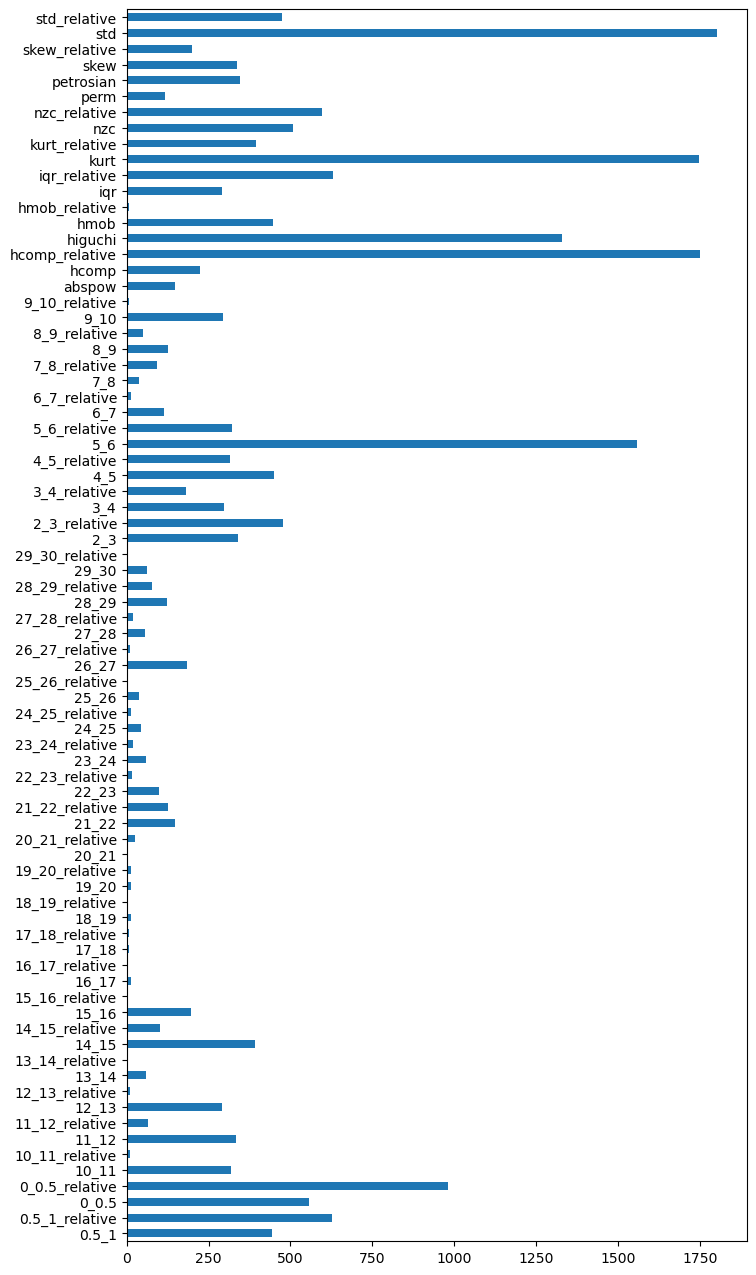

In [101]:
feat_imp_plot = (
    pd.Series(feat_imp_model.feature_importances_, index=X_train.columns).sort_index()
    .plot(kind='barh', figsize=(8, 16))
)
plt.xlabel='Feature Importance'
plt.ylabel='Feature Name'
plt.show()

## K-Fold accuracy

In [99]:
model_data_v3 = features_df.set_index('yasa_time').merge(df.set_index('R.Time')[['Simple.Sleep.Code']], left_index=True, right_index=True)
X, y = model_data_v3.drop(['Simple.Sleep.Code', 'epoch_index'], axis=1), model_data_v3['Simple.Sleep.Code']

In [100]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

# Initialize k-fold
n_splits = 5  # Define the number of splits for k-fold
skf = StratifiedKFold(n_splits=n_splits, shuffle=False)

# Initialize arrays to store accuracies
class_accuracies = []
overall_accuracies = []

# Perform k-fold cross-validation
for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
    print(f'Fold {fold + 1}/{n_splits}')
    kmodel = LGBMClassifier(**best_params, n_jobs=8)
    
    X_tr, X_val = X.iloc[train_index], X.iloc[val_index]
    y_tr, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # Train the model
    kmodel.fit(X_tr, y_tr)
    
    # Predict on validation set
    y_pred = pd.Series(kmodel.predict(X_val), index=y_val.index)
    
    # Calculate accuracy per class
    class_accuracy = []
    for class_label in np.unique(y_val):
        class_accuracy.append(np.sum((y_pred == y_val) & (y_val == class_label)) / 
                              np.sum(y_val == class_label))
    
    class_accuracies.append(class_accuracy)
    overall_accuracies.append(np.mean(y_pred == y_val))

# Calculate mean accuracy per class across folds
mean_class_accuracies = np.mean(class_accuracies, axis=0)
print("Mean accuracy:", round(np.mean(overall_accuracies), 2))
print("Mean class accuracies across folds:")
for i, accuracy in enumerate(mean_class_accuracies):
    print(f"Class {i}: {accuracy}")


Fold 1/5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005326 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19890
[LightGBM] [Info] Number of data points in the train set: 235729, number of used features: 78
[LightGBM] [Info] Start training from score -0.785006
[LightGBM] [Info] Start training from score -2.579783
[LightGBM] [Info] Start training from score -1.943258
[LightGBM] [Info] Start training from score -2.240812
[LightGBM] [Info] Start training from score -1.626677
[LightGBM] [Info] Start training from score -3.821165
Fold 2/5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004828 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19890
[LightGBM] [Info] Number of data points in